In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import gzip
from sklearn.inspection import permutation_importance
import seaborn as sns
from typing import List, Tuple
from sklearn.metrics import confusion_matrix
import csv

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [2]:
# Function to load a gzipped model
def load_model(gzip_path):
    with gzip.GzipFile(gzip_path, "rb") as f:
            model = pickle.load(f)
    
    # with gzip.open(filename, 'rb') as f:
    #     model = joblib.load(f)
    return model

# Function to plot feature importances
def plot_feature_importances(importances, classifier_name, feature_names, top_n=20):
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:top_n]
    sorted_feature_names = [feature_names[i] for i in top_indices]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(top_n), importances[top_indices], align='center')
    plt.xticks(range(top_n), sorted_feature_names, rotation=90)
    plt.title(f'Top {top_n} Feature Importances - {classifier_name}')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

In [3]:
classifiers = {
            "Logistic_Regression": 'Logistic_Regression_BE.sav.gz',
            "Gaussian_NB":'Gaussian_NB_BE.sav.gz',
            "Decision_Tree":'Decision_Tree_BE.sav.gz',
            "Random_Forest":'Random_Forest_BE.sav.gz',
            "Extra_Trees_Classifier":'Extra_Trees_Classifier_BE.sav.gz',
            "Ada_Boost":'Ada_Boost_BE.sav.gz',
            "Gradient_Boosting":'Gradient_Boosting_BE.sav.gz',
            "LightGBM":'LightGBM_BE.sav.gz',
            "Hist_GB":'Hist_GB_BE.sav.gz',
            "XGBoost":'XGBoost_BE.sav.gz',
}

In [4]:
response_data = pd.read_parquet('../data/submission/processed/chrome/08_12_2022/test_set_featurized_response_BE.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow')

In [5]:
request_data = pd.read_parquet('../data/submission/processed/chrome/08_12_2022/test_set_featurized_request_BE.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow')

In [8]:
request_data

,comb_col_non_tracker,comb_col_tracker,accept-language_binary,tracestate_binary,accept-encoding_binary,authorization_binary,content-type_binary,x-youtube-client-version_binary,x-goog-visitor-id_binary,access-control-request-headers_binary,...,sec-ch-ua-model_binary,x-youtube-client-name_binary,traceparent_binary,dpr_binary,sec-fetch-dest_binary,x-client-data_binary,accept_binary,sec-fetch-mode_binary,httpMessageId,tracker
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,87,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,205,1
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,227,1
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,1,1,191,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171740,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,1,0,1,1,138,1
171741,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,97,0
171742,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,229,0
171743,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,239,0


In [9]:
response_data

,comb_col_non_tracker,comb_col_tracker,amp-access-control-allow-source-origin_binary,x-hubspot-correlation-id_binary,x-tt-trace-tag_binary,cdn-pullzone_binary,x-akamai-request-id_binary,requestid_binary,x-vcl-time-ms_binary,cross-origin-opener-policy_binary,...,cdn-uid_binary,x-served-by_binary,x-accel-expires_binary,request-context_binary,x-powered-by_binary,date_binary,content-security-policy_binary,x-request-id_binary,httpMessageId,tracker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,22,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,235,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,146,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,246,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,167,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171739,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,103,1
171740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,197,0
171741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,229,0
171742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,55,0


In [6]:
X = response_data.iloc[:, 2:-2]  # All columns except the last
y = response_data.iloc[:, -1]   # The last column
feature_names = X.columns.tolist()

In [19]:
X = request_data.iloc[:, 2:-2]  # All columns except the last
y = request_data.iloc[:, -1]   # The last column
feature_names = X.columns.tolist()

In [31]:
# # Load the models and plot feature importances
# for name, file in classifiers.items():
#     gzip_path = f"../models/chrome/08_12_2022/response/{file}"
#     clf = load_model(gzip_path)
#     if hasattr(clf, 'feature_importances_'):
#         importances = clf.feature_importances_
#         plot_feature_importances(importances, name, feature_names)
#     else:
#         # Calculate permutation importance
#         result = permutation_importance(clf, X, y, n_repeats=10, random_state=10, n_jobs=-1)
#         importances = result.importances_mean
#         plot_feature_importances(importances, name, feature_names)

In [25]:
# # Plot heatmap with a diverging color palette
# plt.figure(figsize=(16, 10))
# sns.set(font_scale=1.2)
# heatmap = sns.heatmap(
#     feature_importances_top_df,
#     annot=True,
#     cmap='RdBu_r',
#     center=0,
#     linewidths=.5,
#     cbar_kws={'label': 'Normalized Importance'},
#     fmt='.3f',
#     annot_kws={"size": 10}
# )
# heatmap.set_title('Top 20 Feature Importances Across Classifiers', fontsize=16)
# heatmap.set_xlabel('Classifier', fontsize=14)
# heatmap.set_ylabel('Feature', fontsize=14)
# plt.xticks(rotation=45, ha='right', fontsize=12)
# plt.yticks(fontsize=12)
# plt.tight_layout()
# plt.savefig('feature_importances_heatmap.pdf', format='pdf')
# plt.show()

In [7]:
%%time
# Initialize a DataFrame to hold feature importances
feature_importances_dict = {name: pd.Series(dtype=float) for name in classifiers}

# Load the models and compute feature importances
for name, file in classifiers.items():
    gzip_path = f"../models/classifiers_submission/chrome/08_12_2022/response/{file}" # do not forget to change filename to response or request 
    clf = load_model(gzip_path)
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    else:
        # Calculate permutation importance
        result = permutation_importance(clf, X, y, n_repeats=10, random_state=10, n_jobs=-1)
        importances = result.importances_mean
    
    # Normalize importances
    importances_normalized = importances / np.sum(importances)
    
    # Store in dictionary
    feature_importances_dict[name] = pd.Series(importances_normalized, index=feature_names)

# Combine top features from all classifiers
combined_features = pd.concat(feature_importances_dict.values()).groupby(level=0).sum()
top_combined_features = combined_features.nlargest(20).index

/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/wolfrieder/Documents/github_repos/thesis_project_v2/venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 8.22 s, sys: 10.3 s, total: 18.5 s
Wall time: 5min 54s


In [8]:
top_combined_features = combined_features.nlargest(10).index

In [9]:
# Create DataFrame for heatmap
feature_importances_top_df = pd.DataFrame({name: feature_importances_dict[name].reindex(top_combined_features).fillna(0) for name in classifiers})

# Function to insert a newline character after each '-'
def insert_line_breaks(text):
    return text.replace('-', '-\n')

# Transform feature names for display and add line breaks for long names
feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()
feature_importances_top_df.index = feature_importances_top_df.index.map(insert_line_breaks)

# feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()

In [10]:
feature_importances_top_df

,Logistic_Regression,Gaussian_NB,Decision_Tree,Random_Forest,Extra_Trees_Classifier,Ada_Boost,Gradient_Boosting,LightGBM,Hist_GB,XGBoost
Last-\nModified,0.032019,0.021858,0.207734,0.207575,0.073302,0.06,0.196808,0.024667,0.101347,0.093088
Cross-\nOrigin-\nResource-\nPolicy,0.173894,0.024421,0.101444,0.099598,0.070666,0.02,0.181782,0.029667,0.207373,0.072466
P3P,0.028474,0.137716,0.053114,0.051838,0.045224,0.04,0.067616,0.028333,0.042666,0.048718
Accept-\nRanges,0.015227,0.014901,0.092950,0.093548,0.054608,0.02,0.080213,0.022000,0.058605,0.035364
Pragma,0.055363,0.096311,0.019547,0.019695,0.052316,0.02,0.076238,0.022667,0.046465,0.021477
Etag,0.019041,0.012004,0.028627,0.028996,0.066874,0.02,0.054693,0.020000,0.053055,0.016981
X-\nFrame-\nOptions,0.054521,0.022331,0.011094,0.010370,0.016382,0.02,0.035474,0.025667,0.068948,0.018006
Content-\nEncoding,0.010573,0.000128,0.026230,0.025977,0.024589,0.04,0.023513,0.033667,0.038372,0.011309
Access-\nControl-\nAllow-\nCredentials,0.043253,0.028500,0.013975,0.014417,0.027097,0.02,0.022960,0.028333,0.022403,0.007275
Content-\nSecurity-\nPolicy-\nReport-\nOnly,0.021271,0.077574,0.003111,0.003804,0.012150,0.02,0.021367,0.012333,0.022106,0.021392


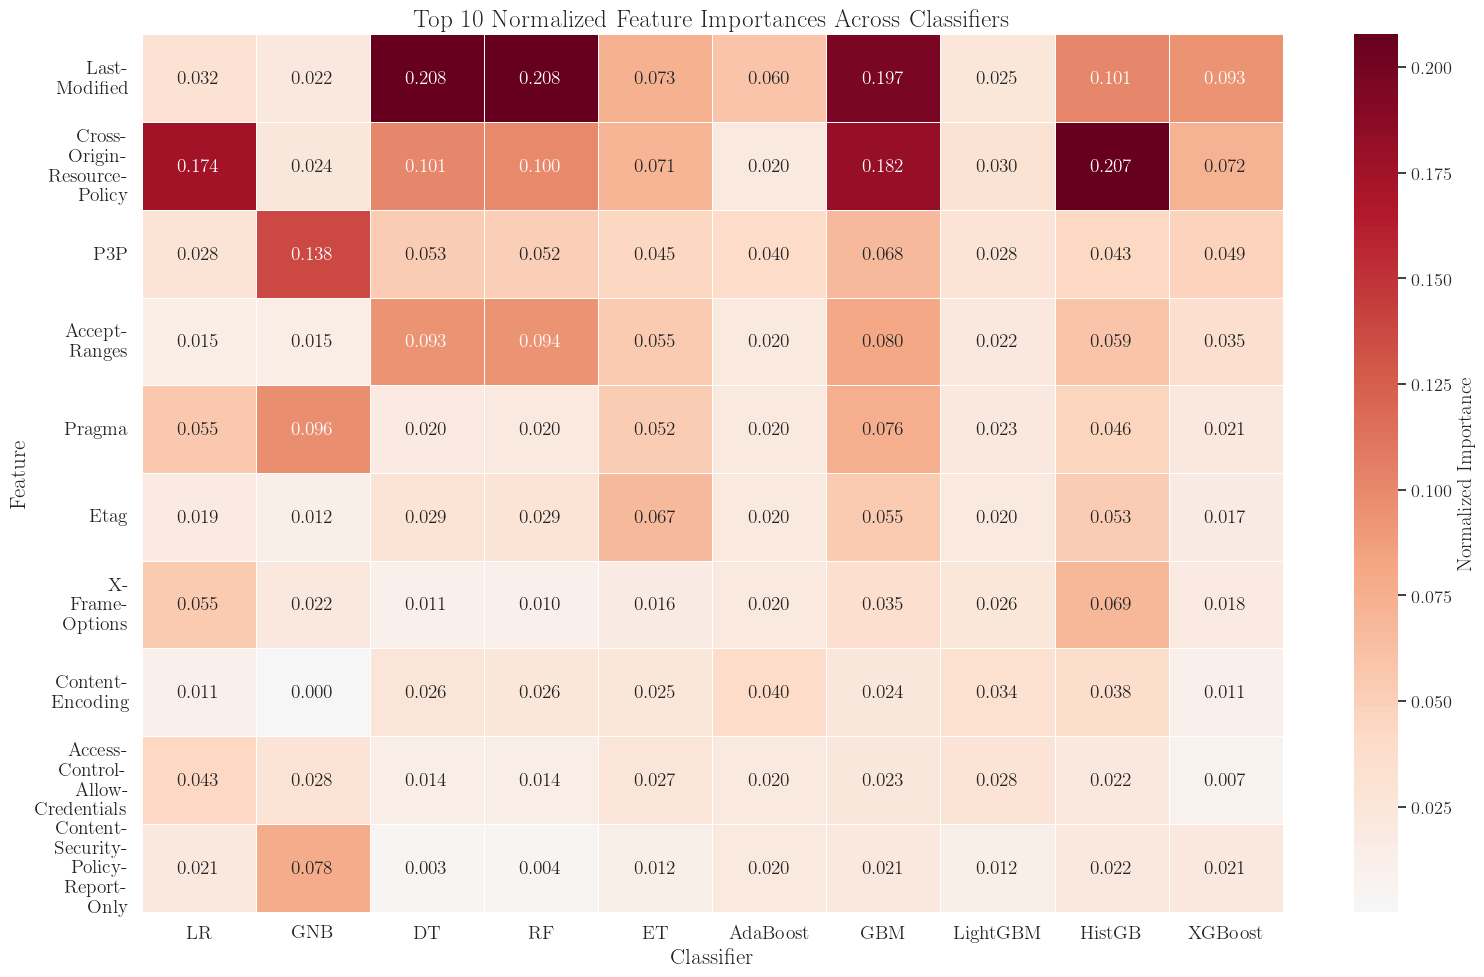

In [13]:
# Plot heatmap with a diverging color palette
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.2)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    # "pdf.fonttype": 3,
    "text.latex.preamble": r"\usepackage[T1]{fontenc}",
    })
heatmap = sns.heatmap(
    feature_importances_top_df,
    annot=True,
    cmap='RdBu_r',
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Normalized Importance'},
    fmt='.3f',
    annot_kws={"size": 14, "weight": "bold"}
)
custom_labels = ["LR", "GNB", "DT", "RF", "ET", "AdaBoost", "GBM", "LightGBM", "HistGB", "XGBoost"]

heatmap.set_title('Top 10 Normalized Feature Importances Across Classifiers', fontsize=18)
heatmap.set_xlabel('Classifier', fontsize=16)
heatmap.set_ylabel('Feature', fontsize=16)
heatmap.set_xticklabels(custom_labels, rotation=0, ha='center', fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig('feature_importances_heatmap.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

gs -dCompatibilityLevel=1.4 -dPDFSETTINGS=/prepress -dEmbedAllFonts=true -dSubsetFonts=true \
   -dCompressFonts=true -r300 -sDEVICE=pdfwrite -o output.pdf -f feature_importances_heatmap.pdf

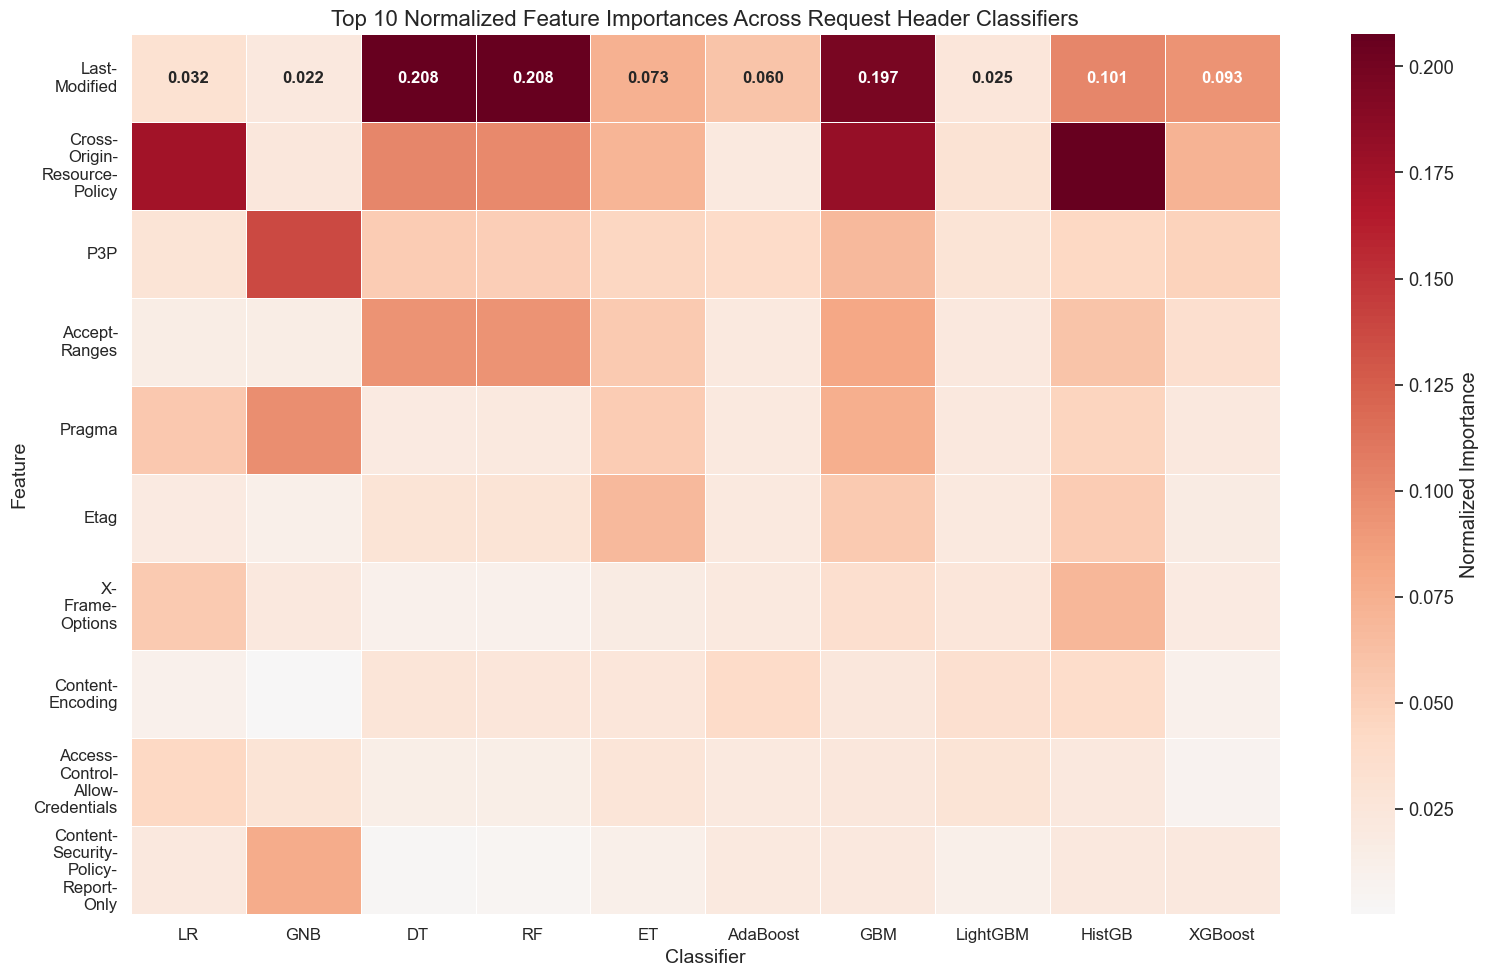

In [15]:
# Create DataFrame for heatmap
feature_importances_top_df = pd.DataFrame({name: feature_importances_dict[name].reindex(top_combined_features).fillna(0) for name in classifiers})

# Function to insert a newline character after each '-'
def insert_line_breaks(text):
    return text.replace('-', '-\n')

# Transform feature names for display and add line breaks for long names
feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()
feature_importances_top_df.index = feature_importances_top_df.index.map(insert_line_breaks)

# feature_importances_top_df.index = feature_importances_top_df.index.str.replace('_binary', '').str.replace('_', ' ').str.title()



# Plot heatmap with a diverging color palette
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(
    feature_importances_top_df,
    annot=True,
    cmap='RdBu_r',
    center=0,
    linewidths=.5,
    cbar_kws={'label': 'Normalized Importance'},
    fmt='.3f',
    annot_kws={"size": 12, "weight": "bold"}
)
custom_labels = ["LR", "GNB", "DT", "RF", "ET", "AdaBoost", "GBM", "LightGBM", "HistGB", "XGBoost"]

heatmap.set_title('Top 10 Normalized Feature Importances Across Request Header Classifiers', fontsize=16)
heatmap.set_xlabel('Classifier', fontsize=14)
heatmap.set_ylabel('Feature', fontsize=14)
# plt.xticks(ticks=np.arange(len(custom_labels)), labels=custom_labels, rotation=90, ha='center', fontsize=12)
heatmap.set_xticklabels(custom_labels, rotation=0, ha='center', fontsize=12)
plt.yticks(fontsize=12)

# plt.savefig('request_performance_comparison.pdf', bbox_inches='tight', pad_inches=0.1)
plt.tight_layout()
# plt.savefig('feature_importances_heatmap_req.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()

In [57]:
response_data[['cross-origin-resource-policy_binary', 'tracker']].groupby('tracker').count()

In [58]:
gzip_path = f"../models/chrome/08_12_2022/response/LightGBM_BE.sav.gz"
clf = load_model(gzip_path)

In [60]:
clf.feature_importances_ / np.sum(clf.feature_importances_)

### Frequency Plot

In [ ]:
chrome_old = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/merged_data.parquet.gzip", engine="pyarrow",
            dtype_backend="pyarrow"
)

chrome_new = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data.parquet.gzip', engine="pyarrow", dtype_backend="pyarrow")

firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/merged_data.parquet.gzip', engine="pyarrow",
            dtype_backend="pyarrow")

brave = pd.read_parquet('../data/processed/brave/08_12_2022/merged_data.parquet.gzip', engine="pyarrow",
            dtype_backend="pyarrow")

In [24]:
# Load the datasets
baseline_file_path = '../models/result_metrics/t.ex-Graph (FQDN)-pretty.csv'
http_response_file_path = '../models/result_metrics/chrome_08_12_2022_test_set_response.csv'
http_request_file_path = '../models/result_metrics/chrome_08_12_2022_test_set_request.csv'

baseline_data = pd.read_csv(baseline_file_path)
http_response_data = pd.read_csv(http_response_file_path)
http_request_data = pd.read_csv(http_request_file_path)

# Extracting Random Forest data for the three datasets
baseline_rf = baseline_data[baseline_data['t.ex-Graph (FQDN)'] == 'RandomForestClassifier']
http_response_rf = http_response_data[http_response_data['Unnamed: 0'] == 'Random_Forest']
http_request_rf = http_request_data[http_request_data['Unnamed: 0'] == 'Random_Forest']

# Select and rename columns for consistency
baseline_rf_selected = baseline_rf[['logloss', 'auprc', 'balanced_accuracy', 'f1_score', 'precision', 'recall', 'matthews_corrcoef']]
baseline_rf_selected.columns = ['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC']

http_response_rf_selected = http_response_rf[['test_log_loss', 'test_aupcr', 'test_balanced_accuracy', 'test_f1', 'test_precision', 'test_recall', 'test_mcc']]
http_response_rf_selected.columns = ['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC']

http_request_rf_selected = http_request_rf[['test_log_loss', 'test_aupcr', 'test_balanced_accuracy', 'test_f1', 'test_precision', 'test_recall', 'test_mcc']]
http_request_rf_selected.columns = ['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC']

# Combine data into a single dataframe
combined_data = {
    't.ex-Graph Baseline': baseline_rf_selected.iloc[0].values,
    'HTTP Response Headers': http_response_rf_selected.iloc[0].values,
    'HTTP Request Headers': http_request_rf_selected.iloc[0].values
}
combined_df = pd.DataFrame(combined_data, index=['Log loss', 'AUPRC', 'BACC', 'F1', 'Precision', 'Recall', 'MCC'])

# Modify the combined dataframe
combined_df.loc['Log loss'] = 1 - combined_df.loc['Log loss']
combined_df.rename(index={'Log loss': '1 - Log loss', 'F1': 'F1-Score'}, inplace=True)

# Plotting the combined data with updated values and labels
fig, ax1 = plt.subplots(figsize=(12, 6))

# Define the lines and colors for each version of Random Forest
colors = ['#1f77b4','#2ca02c','#ff7f0e']
labels = ['t.ex-Graph Baseline', 'HTTP Response Headers', 'HTTP Request Headers']

for label, color in zip(labels, colors):
    ax1.plot(combined_df.index, combined_df[label], marker='o', linestyle='-', label=label, color=color)

# Set labels, title, and legend for the primary axis
ax1.set_xlabel('Metrics', fontsize=14)
ax1.set_ylabel('Score', fontsize=14)
ax1.set_title('Performance of RF classifiers', fontsize=16)
ax1.set_xticks(np.arange(len(combined_df.index)))
ax1.set_xticklabels(combined_df.index, fontsize=12)
ax1.legend(fontsize=12, loc='lower right')

# Create a secondary y-axis to show the metrics
ax2 = ax1.twinx()
ax2.set_yticks([])  # Hide secondary y-axis ticks

# Improve layout
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('request_performance_comparison.pdf', bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.show()

### Predicted Labels Comparison

In [30]:
def test_models(
    models: List[str], X_test: pd.DataFrame, y_test: pd.Series, http_message: str
) -> pd.DataFrame:
    """
    Evaluate the performance of multiple classification models on the test
    dataset and return the predictions along with the true labels.

    Parameters
    ----------
    models : List[str]
        A list of model names to be evaluated. Each model should have a
        corresponding saved binary file in the specified directory with the
        format "{model_name}_binary.sav".

    X_test : pd.DataFrame
        The test dataset containing the feature values.

    y_test : pd.Series
        The true labels for the test dataset.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the predictions and true labels for each model.
    """
    all_predictions = []

    for model_name in models:
        print(f"Evaluating {model_name}...")

        filename = f"{model_name}_BE.sav.gz"
        gzip_path = f"../models/chrome/08_12_2022/{http_message}/{filename}"

        with gzip.GzipFile(gzip_path, "rb") as f:
            best_estimator = pickle.load(f)

        y_pred_test = best_estimator.predict(X_test)

        all_predictions.append(pd.DataFrame({
            'model': model_name,
            'httpMessageId': X_test.index,
            'true_label': y_test.values,
            'predicted_label': y_pred_test
        }))

    predictions_df = pd.concat(all_predictions, ignore_index=True)

    return predictions_df

In [27]:
def test_models_run(
    test_data: pd.DataFrame,
    http_message: str,
) -> pd.DataFrame:
    """
    Load test data, evaluate models, and return the predictions and true labels.

    Parameters
    ----------
    test_data_file_path : str
        The file path to the test data (without extension).

    http_message : str
        The type of HTTP message (e.g., 'response' or 'request').

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the predictions and true labels for each model.
    """
    # test_data = pd.read_parquet(f"{test_data_file_path}.parquet.gzip")
    X_test, y_test = test_data.iloc[:, 2:-2], test_data["tracker"]

    models = [
        "Logistic_Regression",
        "Gaussian_NB",
        "Decision_Tree",
        "Random_Forest",
        "Extra_Trees_Classifier",
        "Ada_Boost",
        "Gradient_Boosting",
        "LightGBM",
        "Hist_GB",
        "XGBoost",
    ]

    predictions_df = test_models(models, X_test, y_test, http_message)

    return predictions_df

In [37]:
chrome_old = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_featurized_response_BE.parquet.gzip"
)

chrome_new = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data_featurized_response_BE.parquet.gzip')

firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/merged_data_featurized_response_BE.parquet.gzip')

brave = pd.read_parquet('../data/processed/brave/08_12_2022/merged_data_featurized_response_BE.parquet.gzip')

In [39]:
chrome_old_request = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_featurized_request_BE.parquet.gzip"
)

In [40]:
# Test response classifier models
predictions_response = test_models_run(chrome_old, 'response')
# Test request classifier models
predictions_request = test_models_run(chrome_old_request, 'request')

In [42]:
predictions_response

In [58]:
# Add suffixes to distinguish between the classifier types
predictions_response = predictions_response.rename(columns={'predicted_label': 'predicted_label_response', 'true_label': 'true_label_response'})
predictions_request = predictions_request.rename(columns={'predicted_label': 'predicted_label_request', 'true_label': 'true_label_request'})

# Merge predictions on 'httpMessageId' and 'model'
merged_predictions = predictions_response.merge(
    predictions_request, on=['httpMessageId', 'model'], suffixes=('_response', '_request'))

# Identify cases where the response classifier identified positive classes that the request classifier did not
positive_cases = merged_predictions[(merged_predictions['true_label_response'] == 1) &
                                    (merged_predictions['predicted_label_response'] == 1) &
                                    (merged_predictions['predicted_label_request'] == 0)]

# Summary table
summary_table = positive_cases[['httpMessageId', 'model', 'true_label_response', 'predicted_label_response', 'predicted_label_request']]

# Display the summary table
summary_table

In [51]:
merged_predictions

In [55]:
# Add a column to classify the combined predictions based on true labels
merged_predictions['result'] = merged_predictions.apply(
    lambda row: (
        'True for both' if row['predicted_label_response'] == 1 and row['predicted_label_request'] == 1 else
        'True for response, False for request' if row['predicted_label_response'] == 1 and row['predicted_label_request'] == 0 else
        'False for response, True for request' if row['predicted_label_response'] == 0 and row['predicted_label_request'] == 1 else
        'False for both'
    ), axis=1
)

# Add a column to indicate if the prediction matches the true label
merged_predictions['match_true_label'] = merged_predictions.apply(
    lambda row: (
        'True Positive' if row['true_label_response'] == 1 and row['predicted_label_response'] == 1 else
        'True Negative' if row['true_label_response'] == 0 and row['predicted_label_response'] == 0 else
        'False Positive' if row['true_label_response'] == 0 and row['predicted_label_response'] == 1 else
        'False Negative'
    ), axis=1
)

# Create a contingency table that includes the true label matches
contingency_table = pd.crosstab(
    index=[merged_predictions['result'], merged_predictions['match_true_label']],
    columns='count'
).reset_index()

# Display the contingency table
contingency_table

In [56]:
# Plot to visualize the counts for each combination of predictions and true label matches
plt.figure(figsize=(14, 8))
sns.barplot(x='result', y='count', hue='match_true_label', data=contingency_table, palette='viridis')
plt.title('Counts of Prediction Combinations from Response and Request Classifiers with True Labels')
plt.xlabel('Prediction Combination')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='True Label Match')
plt.tight_layout()
plt.show()

In [62]:
def analyze_predictions(merged_predictions: pd.DataFrame, selected_classifier: str = None):
    """
    Analyze and visualize the predictions, optionally filtering by a specific classifier,
    and plot the results as percentages.

    Parameters
    ----------
    merged_predictions : pd.DataFrame
        The dataframe containing merged predictions from response and request classifiers.
    selected_classifier : str, optional
        The name of the classifier to filter by. If None, analyze all classifiers.
    """
    # Filter the dataframe based on the selected classifier
    if selected_classifier:
        merged_predictions = merged_predictions[merged_predictions['model'] == selected_classifier]

    # Add a column to classify the combined predictions based on true labels
    merged_predictions['result'] = merged_predictions.apply(
        lambda row: (
            'True for both' if row['predicted_label_response'] == 1 and row['predicted_label_request'] == 1 else
            'True for response, False for request' if row['predicted_label_response'] == 1 and row['predicted_label_request'] == 0 else
            'False for response, True for request' if row['predicted_label_response'] == 0 and row['predicted_label_request'] == 1 else
            'False for both'
        ), axis=1
    )

    # Add a column to indicate if the prediction matches the true label
    merged_predictions['match_true_label'] = merged_predictions.apply(
        lambda row: (
            'True Positive' if row['true_label_response'] == 1 and row['predicted_label_response'] == 1 else
            'True Negative' if row['true_label_response'] == 0 and row['predicted_label_response'] == 0 else
            'False Positive' if row['true_label_response'] == 0 and row['predicted_label_response'] == 1 else
            'False Negative'
        ), axis=1
    )

    # Create a contingency table that includes the true label matches
    contingency_table = pd.crosstab(
        index=[merged_predictions['result'], merged_predictions['match_true_label']],
        columns='count'
    ).reset_index()

    # Calculate the total count for each result type to compute percentages
    total_counts = contingency_table.groupby('result')['count'].sum().reset_index()
    total_counts.columns = ['result', 'total']

    # Merge the total counts back into the contingency table
    contingency_table = contingency_table.merge(total_counts, on='result')

    # Calculate the percentage for each combination
    contingency_table['percentage'] = (contingency_table['count'] / contingency_table['total']) * 100

    # Display the contingency table
    print(contingency_table)

    # Plot to visualize the percentages for each combination of predictions and true label matches
    plt.figure(figsize=(14, 8))
    sns.barplot(x='result', y='percentage', hue='match_true_label', data=contingency_table, palette='viridis')
    plt.title(f'Percentages of Prediction Combinations from Response and Request Classifiers with True Labels\n(Classifier: {selected_classifier if selected_classifier else "All"})')
    plt.xlabel('Prediction Combination')
    plt.ylabel('Percentage')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.legend(title='True Label Match')
    plt.tight_layout()
    plt.show()

In [63]:
analyze_predictions(merged_predictions, selected_classifier='Extra_Trees_Classifier')

In [64]:
def calculate_additional_metrics(merged_predictions: pd.DataFrame, selected_classifier: str = None):
    """
    Calculate additional metrics for a given classifier.

    Parameters
    ----------
    merged_predictions : pd.DataFrame
        The dataframe containing merged predictions from response and request classifiers.
    selected_classifier : str, optional
        The name of the classifier to filter by. If None, analyze all classifiers.

    Returns
    -------
    dict
        A dictionary containing the calculated metrics.
    """
    # Filter the dataframe based on the selected classifier
    if selected_classifier:
        merged_predictions = merged_predictions[merged_predictions['model'] == selected_classifier]

    # Calculate how often the response classifier correctly predicted the label while the request classifier did not
    correct_response_incorrect_request = merged_predictions[
        (merged_predictions['true_label_response'] == merged_predictions['predicted_label_response']) & 
        (merged_predictions['true_label_response'] != merged_predictions['predicted_label_request'])
    ].shape[0]

    # Calculate how often the response classifier predicted "yes" (1) when the true label was 0
    false_positive_response = merged_predictions[
        (merged_predictions['true_label_response'] == 0) & 
        (merged_predictions['predicted_label_response'] == 1)
    ].shape[0]

    total_predictions = merged_predictions.shape[0]

    metrics = {
        'correct_response_incorrect_request': correct_response_incorrect_request,
        'false_positive_response': false_positive_response,
        'total_predictions': total_predictions,
        'correct_response_incorrect_request_percentage': (correct_response_incorrect_request / total_predictions) * 100,
        'false_positive_response_percentage': (false_positive_response / total_predictions) * 100
    }

    return metrics

In [65]:
calculate_additional_metrics(merged_predictions, selected_classifier='Logistic_Regression')

### Radar Plot For Cross-Browser Comparison

In [67]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            lines, texts = self.set_thetagrids(np.degrees(theta), labels)
            for text in texts:
                text.set_zorder(100)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [124]:
def load_csv(file_path, headers):
    """Load CSV data and return a dictionary of model:metrics."""
    data = {}
    with open(file_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            model_name = row['']
            metrics = [float(row[col]) for col in headers]
            data[model_name] = metrics
    return data

def load_data():
    
    path = '../models/result_metrics/'

    # Assuming all CSV files are in the same directory called 'csv_directory'
    csv_files = [f'{path}chrome_08_12_2022_test_set_response.csv', f'{path}chrome_03_29_2023_merged_data_response.csv', f'{path}firefox_08_12_2022_merged_data_response.csv', f'{path}brave_08_12_2022_merged_data_response.csv']

    # The headers for metrics we're interested in.
    headers = ['test_accuracy','test_log_loss','test_auc','test_aupcr','test_balanced_accuracy','test_f1','test_precision','test_recall','test_mcc']

    aggregated_data = {}

    for csv_file in csv_files:
        file_data = load_csv(csv_file, headers)
        for model, metrics in file_data.items():
            if model not in aggregated_data:
                aggregated_data[model] = []
            aggregated_data[model].append(metrics)

    # Normalize test_log_loss values
    # Get the global min and max test_log_loss values
    all_log_loss_values = [metrics[headers.index('test_log_loss')] for all_metrics in aggregated_data.values() for metrics in all_metrics]
    min_val = min(all_log_loss_values)
    max_val = max(all_log_loss_values)

    # Normalize test_log_loss values using the global min and max
    for model, all_metrics in aggregated_data.items():
        for metrics in all_metrics:
            index = headers.index('test_log_loss')
            metrics[index] = (metrics[index] - min_val) / (max_val - min_val) if max_val != min_val else 0.5

    # Calculate 1 - log-loss score
    # one_minus_log_loss_scores = {}
    # for model, all_metrics in aggregated_data.items():
    #     log_losses = [metrics[headers.index('test_log_loss')] for metrics in all_metrics]
    #     avg_log_loss = sum(log_losses) / len(log_losses)  # Average log-loss for the model
    #     one_minus_log_loss_scores[model] = 1 - avg_log_loss

    # Convert dictionary to the desired format
    # final_data = [headers + ['1_minus_log_loss']]
    # for model, all_metrics in aggregated_data.items():
    #     avg_metrics = [sum(metric)/len(metric) for metric in zip(*all_metrics)]
    #     final_data.append([model] + avg_metrics + [one_minus_log_loss_scores[model]])
        
    # Convert dictionary to the desired format
    final_data = [headers]
    for model, all_metrics in aggregated_data.items():
        final_data.append((model, all_metrics))

    return final_data

In [69]:
def filter_models(model_list, data):
    """
    Filter the data for the given list of model names.

    Parameters:
    - model_list: List of model names to filter.
    - data: The data structure to filter.

    Returns:
    - A subset of the data containing only the given models.
    """
    filtered_data = [data[0]]  # add the headers
    for model_data in data[1:]:
        if model_data[0] in model_list:
            filtered_data.append(model_data)
    return filtered_data

In [70]:
def adjust_label_alignment(ax):
    """Adjust the alignment of radar spine labels."""
    # Get the labels
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()

    for label, tick in zip(labels, ax.xaxis.get_major_ticks()):
        # Get the label's position
        x, y = label.get_position()

        # Based on its position, set the alignment
        if x == 0:
            label.set_horizontalalignment('center')
        elif x < 3:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')

In [128]:
filtered_models = ['Logistic_Regression', 'Extra_Trees_Classifier', 'XGBoost']
data = filter_models(filtered_models, load_data())
#spoke_labels = data.pop(0)
data.pop(0)
spoke_labels = ['Accuracy', '1 - Log-loss', 'ROC-AUC', 'AUPRC', 'BACC', 'F1-Score', 'Precision', 'Recall', 'MCC']
# selected_indices = [0, 1, 2, 4, 5, 6]  # Indices of the selected metrics
# spoke_labels = ['1 - Log-loss', 'ROC-AUC', 'AUPRC', 'BACC', 'F1-Score', 'MCC']

N = len(spoke_labels)

theta = radar_factory(N, frame='polygon')

fig, axs = plt.subplots(figsize=(17, 4), nrows=1, ncols=3,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.15, hspace=0.20, top=0.80, bottom=0.05)
plt.rcParams.update({'mathtext.default': 'regular'})

colors = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]
linestyles = ["-", "--", "-.", ":", "-", "--", "-."]

# Plot the four cases from the example data on separate axes
for ax, (title, case_data) in zip(axs.flat, data):
    # modify grid and background
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.grid(color='lightgrey')  # Set the gridline color to light grey
    ax.set_facecolor('none')
    ax.spines['polar'].set_edgecolor('lightgrey')
    ax.set_ylim(0, 1)

    # set title
    ax.set_title(title.replace('_', ' '), weight='bold', position=(0.5, 1),
                 horizontalalignment='center')

    # set labels and label position
    ax.set_varlabels(spoke_labels)
    adjust_label_alignment(ax)

    ticks = ax.xaxis.get_major_ticks()
    for tick in ticks:
        tick.set_pad(-2)

    # plot data
    for d, color, ls in zip(case_data, colors, linestyles):
        d = d[:1] + [1 - d[1]] + d[2:]  # Convert log-loss to 1 - log-loss on the fly
        ax.plot(theta, d, color=color, linestyle=ls)
        # ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')


# add legend relative to top-left plot
labels = ('$Chrome_{22}$', '$Chrome_{23}$', '$Firefox_{22}$', '$Brave_{22}$')
legend = axs[2].legend(labels, loc=(1.05, 0.5), bbox_to_anchor=(1.05, 0.7))
legend.set_title('Browser')
# Set the legend properties for transparent background and light grey border
legend.get_frame().set_facecolor('none')  # Transparent background
legend.get_frame().set_edgecolor('lightgrey')  # Light grey border
legend.get_frame().set_linewidth(1.0)  # Set the linewidth to 1.0

fig.text(0.5, 0.94, 'Cross-browser and longitudinal performance of selected classifiers',
         verticalalignment='bottom',
         horizontalalignment='center', color='black',
         size=14)

plt.tight_layout()
plt.savefig('spider.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)

plt.show()

### ECDF and Feature Similarity

In [2]:
chrome_old = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_processed_response.parquet.gzip", engine='pyarrow', dtype_backend='pyarrow'
)

chrome_new = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data_processed_response.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow')

firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/merged_data_processed_response.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow')

brave = pd.read_parquet('../data/processed/brave/08_12_2022/merged_data_processed_response.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow')

In [6]:
# Plotting
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

cl_values = chrome_old[["content-length", "tracker"]].dropna().astype('Int32')
cl_values_chrome = chrome_new[["content-length", "tracker"]].dropna().astype('Int32')

# Add row identifiers
fig.text(-0.025, 0.75, '(A)', ha='center', va='center', fontsize=20)
fig.text(-0.025, 0.25, '(B)', ha='center', va='center', fontsize=20)

# ECDF plot for Chrome (example data)
sns.ecdfplot(data=cl_values[cl_values['content-length'] < 10000], x="content-length", hue='tracker', ax=axes[0, 0], color='blue')
axes[0, 0].set_title('$Chrome_{22}$: ECDF of Content-Length Header', fontsize=14)
axes[0, 0].set_xlabel('Content-Length Value', fontsize=14)
axes[0, 0].set_ylabel('Cumulative Probability', fontsize=14)
labels = ('Tracker', 'Non-Tracker')
# legend = axs[2].legend(labels, loc=(1.05, 0.5), bbox_to_anchor=(1.05, 0.7))
# handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(labels=labels, title='Classification')
axes[0, 0].tick_params(axis='y', labelsize=12)
axes[0, 0].tick_params(axis='x', labelsize=12)

# axes[0, 0].legend(title='Classification')

# ECDF plot for Brave (example data)
sns.ecdfplot(data=cl_values_chrome[cl_values_chrome['content-length'] < 10000], x="content-length", hue='tracker', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('$Chrome_{23}$: ECDF of Content-Length Header', fontsize=14)
axes[0, 1].set_xlabel('Content-Length Value', fontsize=14)
axes[0, 1].set_ylabel('Cumulative Probability', fontsize=14)
axes[0, 1].legend(labels=labels, title='Classification')
axes[0, 1].tick_params(axis='y', labelsize=12)
axes[0, 1].tick_params(axis='x', labelsize=12)

# Relative Frequency plot for Chrome vs Firefox
feature = 'x-xss-protection'
# feature = 'cross-origin-resource-policy'

df_chrome_firefox = pd.DataFrame({
    feature: np.concatenate(
        (chrome_old.loc[:, feature], firefox.loc[:, feature])),
    'set': ['Chrome'] * chrome_old.shape[0] + ['Firefox'] * firefox.shape[0]
})

# Drop rows with NA values
df_chrome_firefox = df_chrome_firefox.dropna(subset=[feature])

top_n = 5
# Calculate frequencies
frequency = df_chrome_firefox.groupby(['set', feature]).size().reset_index(name='count')

# Identify top N most frequent values across both sets
top_values = frequency.groupby(feature)['count'].sum().nlargest(top_n).index

# Filter data to include only top N values
df_chrome_firefox = df_chrome_firefox[df_chrome_firefox[feature].isin(top_values)]

# Recalculate relative frequencies for filtered data
relative_freq = df_chrome_firefox.groupby(['set', feature]).size().reset_index(name='count')
total_counts = relative_freq.groupby('set')['count'].transform('sum')
relative_freq['relative_frequency'] = relative_freq['count'] / total_counts
relative_freq.sort_values(by='relative_frequency', ascending=False, inplace=True)
sns.barplot(data=relative_freq, x=feature, y='relative_frequency', hue='set', ax=axes[1, 0])
axes[1, 0].set_title('Feature Similarity between Chrome and Firefox', fontsize=14)
axes[1, 0].set_xlabel('Feature Values', fontsize=14)
axes[1, 0].set_ylabel('Relative Frequency', fontsize=14)
labels = ('$Chrome_{22}$', '$Firefox_{23}$')
axes[1, 0].legend(labels=labels, title='Browser')
axes[1, 0].tick_params(axis='y', labelsize=12)
axes[1, 0].tick_params(axis='x', labelsize=12)

# Relative Frequency plot for Chrome vs Brave
df_chrome_brave = pd.DataFrame({
    feature: np.concatenate(
        (chrome_old.loc[:, feature], brave.loc[:, feature])),
    'set': ['Chrome'] * chrome_old.shape[0] + ['Brave'] * brave.shape[0]
})

# Drop rows with NA values
df_chrome_brave = df_chrome_brave.dropna(subset=[feature])

frequency_brave = df_chrome_brave.groupby(['set', feature]).size().reset_index(name='count')

# Identify top N most frequent values across both sets
top_values_brave = frequency_brave.groupby(feature)['count'].sum().nlargest(top_n).index

# Filter data to include only top N values
df_chrome_brave = df_chrome_brave[df_chrome_brave[feature].isin(top_values_brave)]

relative_freq_brave = df_chrome_brave.groupby(['set', feature]).size().reset_index(name='count')
total_counts_brave = relative_freq_brave.groupby('set')['count'].transform('sum')
relative_freq_brave['relative_frequency'] = relative_freq_brave['count'] / total_counts_brave
relative_freq_brave.sort_values(by='relative_frequency', ascending=False, inplace=True)
sns.barplot(data=relative_freq_brave, x=feature, y='relative_frequency', hue='set', ax=axes[1, 1])
axes[1, 1].set_title('Feature Similarity between Chrome and Brave', fontsize=14)
axes[1, 1].set_xlabel('Feature Values', fontsize=14)
axes[1, 1].set_ylabel('Relative Frequency', fontsize=14)
labels = ('$Chrome_{22}$', '$Brave_{23}$')
axes[1, 1].legend(labels=labels, title='Browser')
axes[1, 1].tick_params(axis='y', labelsize=12)
axes[1, 1].tick_params(axis='x', labelsize=12)

# legend.get_frame().set_facecolor('none')  # Transparent background
# legend.get_frame().set_edgecolor('lightgrey')  # Light grey border
# legend.get_frame().set_linewidth(1.0)  # Set the linewidth to 1.0
plt.tight_layout()
# legend color had to be changed manually in a third-party program as we coudnt figure out how
plt.savefig('content_length_comparison.svg', format='svg', bbox_inches='tight', pad_inches=0.1)
plt.show()

We had to change the colors of the lines for the upper two plots manually (tracker and non-tracker) because multiple (should be working) attempts did not work. The same applies for the browser legend in the lower two plots where the color was not accurately shown.   

### Feature Vector Similarity

In [29]:
chrome_data = pd.read_parquet('../data/processed/chrome/08_12_2022/train_set_featurized_response_BE.parquet.gzip').iloc[:, 2:]

In [30]:
chrome_new = pd.read_parquet('../data/processed/chrome/03_29_2023/merged_data_featurized_response_BE.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow').iloc[:, 2:]
firefox = pd.read_parquet('../data/processed/firefox/08_12_2022/merged_data_featurized_response_BE.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow').iloc[:, 2:]
brave = pd.read_parquet('../data/processed/brave/08_12_2022/merged_data_featurized_response_BE.parquet.gzip', engine='pyarrow', dtype_backend='pyarrow').iloc[:, 2:]

In [31]:
chrome_data = chrome_data.drop(columns=['httpMessageId'])
chrome_new = chrome_new.drop(columns=['httpMessageId'])
firefox_data = firefox.drop(columns=['httpMessageId'])
brave_data = brave.drop(columns=['httpMessageId'])

In [32]:
chrome_old_group = chrome_data.iloc[:, :-1].drop_duplicates()
chrome_new_group = chrome_new.iloc[:, :-1].drop_duplicates()
firefox_group = firefox_data.iloc[:, :-1].drop_duplicates()
brave_group = brave_data.iloc[:, :-1].drop_duplicates()

In [33]:
usage_counts = chrome_old_group.copy()

In [34]:
feature_vectors = chrome_data.drop(columns=['tracker'])
tracker_labels = chrome_data['tracker']

In [37]:
feature_vectors_with_labels = pd.concat([tracker_labels, chrome_old_group], axis=1)

In [39]:
unique_counts = feature_vectors_with_labels.groupby(list(feature_vectors.columns) + ['tracker']).size().reset_index(name='count')

In [53]:
feature_vectors_with_labels.value_counts()